In [1]:
import os

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt


from keras.preprocessing import image

from tqdm import tqdm
tqdm.pandas()

Using TensorFlow backend.
C:\Users\Lee Wen Qing\AppData\Roaming\Python\Python37\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
train_df = pd.read_csv('train.csv')

train_df.head(10)

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN
5,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0
6,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0
7,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0
8,d3637a1935a905b3c326af31389cb846,Aortic enlargement,0,R10,1329.0,743.0,1521.0,958.0
9,afb6230703512afc370f236e8fe98806,Pulmonary fibrosis,13,R9,1857.0,1607.0,2126.0,2036.0


In [3]:
class_sample_counts=train_df.groupby(['class_name','class_id']).size().reset_index().rename(columns={0:'count'})
class_sample_counts.sort_values(by='class_id',inplace=True)
class_sample_counts.reset_index(drop=True)

,class_name,class_id,count
0,Aortic enlargement,0,7162
1,Atelectasis,1,279
2,Calcification,2,960
3,Cardiomegaly,3,5427
4,Consolidation,4,556
5,ILD,5,1000
6,Infiltration,6,1247
7,Lung Opacity,7,2483
8,Nodule/Mass,8,2580
9,Other lesion,9,2203


In [4]:
class_name=list((class_sample_counts['class_name']))
print(f'The total number of classes is {len(class_name)}')
print(class_name)

The total number of classes is 15
['Aortic enlargement', 'Atelectasis', 'Calcification', 'Cardiomegaly', 'Consolidation', 'ILD', 'Infiltration', 'Lung Opacity', 'Nodule/Mass', 'Other lesion', 'Pleural effusion', 'Pleural thickening', 'Pneumothorax', 'Pulmonary fibrosis', 'No finding']


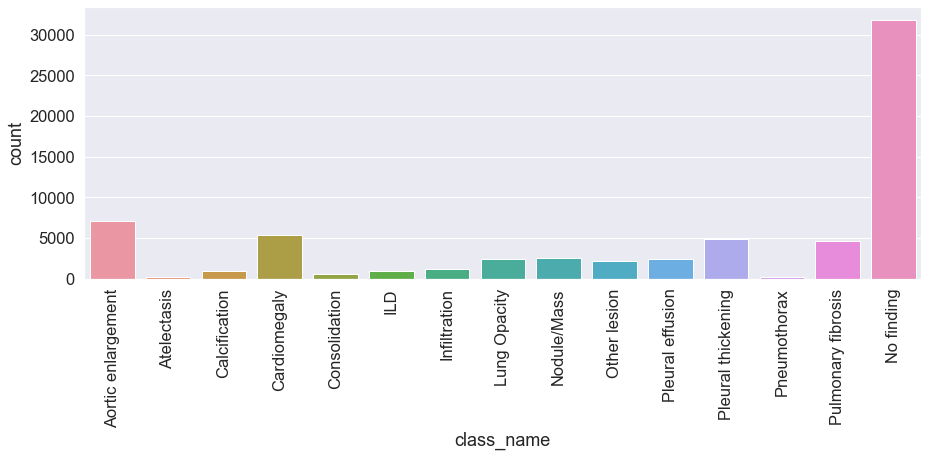

In [5]:
plt.pyplot.figure(figsize=(15,5))
sns.set(font_scale = 1.5)
g=sns.barplot(x='class_name',y='count',data=class_sample_counts)
g=g.set_xticklabels(g.get_xticklabels(), rotation=90)

# Visualisation of Bounding Boxes area for each class

In [6]:
train_df_abnormal=train_df[train_df['class_id']!=14].reset_index(drop=True)
train_df_abnormal

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0
...,...,...,...,...,...,...,...,...
36091,b53d1dd80e99ca6bcef9d592f65d3321,Pleural effusion,10,R9,240.0,1550.0,562.0,2001.0
36092,26d1d5a0ef2e692c6340e74859ffdc53,Pulmonary fibrosis,13,R10,1163.0,787.0,1338.0,941.0
36093,22672ab82c290c20b86863291e25ef6c,ILD,5,R9,299.0,664.0,794.0,1508.0
36094,db169d0be36123bd55b866d6aa73983b,Other lesion,9,R8,6.0,670.0,272.0,1736.0


In [7]:
train_df_abnormal['area']=(train_df_abnormal['x_max']-train_df_abnormal['x_min'])*(train_df_abnormal['y_max']-train_df_abnormal['y_min'])

In [8]:
class_wise_area=train_df_abnormal.groupby(['class_name','class_id'])['area'].mean().reset_index()
class_wise_area

,class_name,class_id,area
0,Aortic enlargement,0,111786.365820
1,Atelectasis,1,392763.050179
2,Calcification,2,92550.651042
3,Cardiomegaly,3,430588.274553
4,Consolidation,4,325284.230216
5,ILD,5,653507.925000
6,Infiltration,6,343015.942261
7,Lung Opacity,7,251134.065244
8,Nodule/Mass,8,73546.351163
9,Other lesion,9,259795.801180


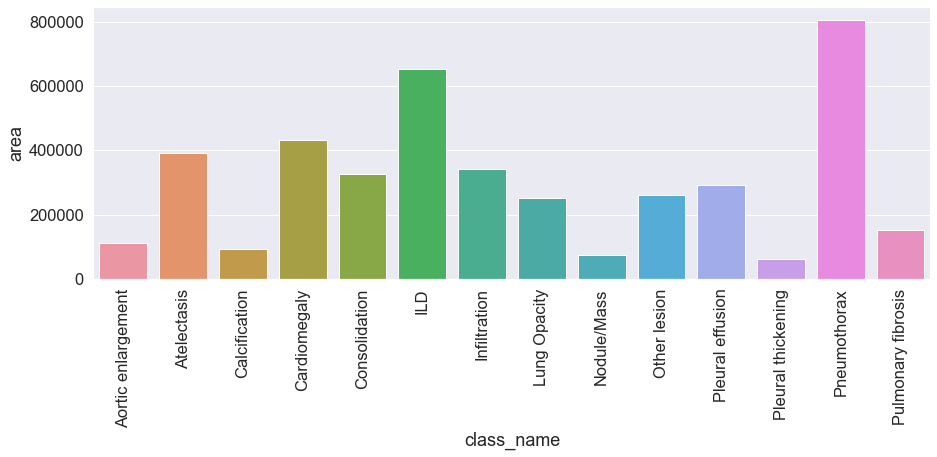

In [9]:
plt.pyplot.figure(figsize=(15,5))
sns.set(font_scale = 1.5)
g=sns.barplot(x='class_name',y='area',data=class_wise_area)
g=g.set_xticklabels(g.get_xticklabels(), rotation=90)